In [1]:
import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from arch import arch_model

plt.style.use('bmh')

In [2]:
data = yf.download('^GSPC', period='10y', interval='1d', auto_adjust=True)
data 

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2012-03-23,1392.780029,1399.180054,1386.869995,1397.109985,3472950000
2012-03-26,1397.109985,1416.579956,1397.109985,1416.510010,3576950000
2012-03-27,1416.550049,1419.150024,1411.949951,1412.520020,3513640000
2012-03-28,1412.520020,1413.650024,1397.199951,1405.540039,3892800000
2012-03-29,1405.390015,1405.390015,1391.560059,1403.280029,3832000000
...,...,...,...,...,...
2022-03-16,4288.140137,4358.899902,4251.990234,4357.859863,5002240000
2022-03-17,4345.109863,4412.669922,4335.649902,4411.669922,4174170000
2022-03-18,4407.339844,4465.399902,4390.569824,4463.120117,6681510000


In [3]:
returns = 100 * data.Close.apply(np.log).diff(1).dropna()
returns

Date
2012-03-26    1.379030
2012-03-27   -0.282075
2012-03-28   -0.495376
2012-03-29   -0.160922
2012-03-30    0.369161
                ...   
2022-03-16    2.213692
2022-03-17    1.227221
2022-03-18    1.159481
2022-03-21   -0.043475
2022-03-22    1.124070
Name: Close, Length: 2515, dtype: float64

In [4]:
split_date = returns.index[-500]
am = arch_model(returns, vol='GARCH', p=1, o=0, q=1, dist='skewt')
res = am.fit(last_obs=split_date, disp='off')

## Parametric VaR

In [5]:
forecasts = res.forecast(reindex=False, start=returns.index[-499])
forecasts.variance

,h.1
Date,
2020-03-31,17.164677
2020-04-01,17.560255
2020-04-02,14.427727
2020-04-03,11.561334
2020-04-06,18.445765
...,...
2022-03-16,2.892338
2022-03-17,2.521535
2022-03-18,2.206684


In [6]:
cond_mean = forecasts.mean
cond_var = forecasts.variance

In [7]:
res.params[-2:]

eta       5.637538
lambda   -0.099783
Name: params, dtype: float64

In [8]:
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
q

array([-2.74754785, -1.64378639])

In [9]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
value_at_risk

,1%,5%
Date,,
2020-03-31,11.316352,6.743438
2020-04-01,11.446773,6.821466
2020-04-02,10.369430,6.176919
2020-04-03,9.275387,5.522382
2020-04-06,11.733501,6.993007
...,...,...
2022-03-16,4.605906,2.728753
2022-03-17,4.296110,2.543410
2022-03-18,4.014644,2.375016


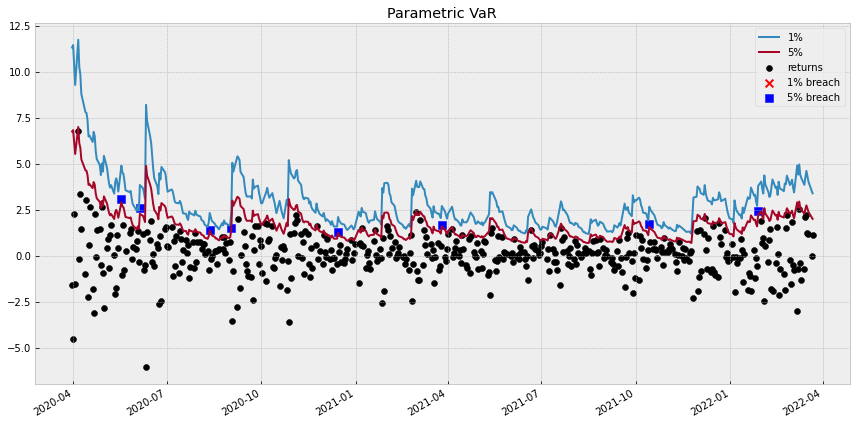

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

value_at_risk.plot(ax=ax)
ax.scatter(returns.index[-499:], returns.iloc[-499:], color='k', label='returns')

breach_1pct = returns.iloc[-499:][returns.iloc[-499:] > value_at_risk['1%']]
ax.scatter(breach_1pct.index, breach_1pct, color='red', marker='x', label='1% breach', s=60)

breach_5pct = returns.iloc[-499:][returns.iloc[-499:] > value_at_risk['5%']]
ax.scatter(breach_5pct.index, breach_5pct, color='blue', marker='s', label='5% breach', s=60)

ax.set_title("Parametric VaR")
ax.legend()
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## Filtered Historical Simulation VaR

In [11]:
std_rets = (returns - res.params['mu']) / res.conditional_volatility
std_rets.dropna(inplace=True)

In [12]:
q = std_rets.quantile([0.01, 0.05])
q

0.01   -2.973146
0.05   -1.792879
dtype: float64

In [13]:
VaR_1pct = -cond_mean - np.sqrt(cond_var) * q[0.01]
VaR_1pct.columns = ['1% VaR']

VaR_5pct = -cond_mean - np.sqrt(cond_var) * q[0.05]
VaR_5pct.columns = ['5% VaR']

value_at_risk = pd.concat([VaR_1pct, VaR_5pct], axis=1)
value_at_risk

,1% VaR,5% VaR
Date,,
2020-03-31,12.251011,7.361131
2020-04-01,12.392142,7.446236
2020-04-02,11.226338,6.743229
2020-04-03,10.042465,6.029325
2020-04-06,12.702412,7.633337
...,...,...
2022-03-16,4.989578,2.982312
2022-03-17,4.654345,2.780159
2022-03-18,4.349768,2.596491


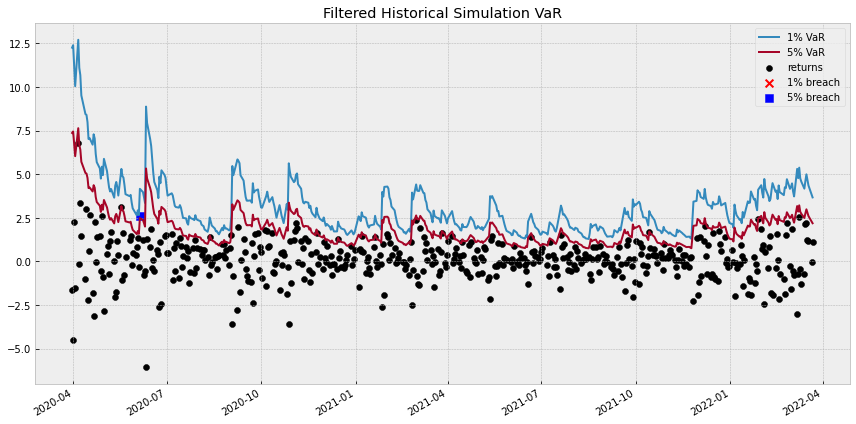

In [14]:
fig, ax = plt.subplots(figsize=(12,6))

value_at_risk.plot(ax=ax)
ax.scatter(returns.index[-499:], returns.iloc[-499:], color='k', label='returns')

breach_1pct = returns.iloc[-499:][returns.iloc[-499:] > value_at_risk['1% VaR']]
ax.scatter(breach_1pct.index, breach_1pct, color='red', marker='x', label='1% breach', s=60)

breach_5pct = returns.iloc[-499:][returns.iloc[-499:] > value_at_risk['5% VaR']]
ax.scatter(breach_5pct.index, breach_5pct, color='blue', marker='s', label='5% breach', s=60)

ax.set_title("Filtered Historical Simulation VaR")
ax.legend()
ax.set_xlabel('')
plt.tight_layout()
plt.show()